In [214]:
import nltk
# nltk.download('all')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import snscrape.modules.twitter as sntwitter
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def download_tweets(tag):
    tweets_list = []
    txt = ""
    for i, tweet in enumerate(
            sntwitter.TwitterSearchScraper(tag + ' lang:en').get_items()):
        if i >= 1000:
            break
        tweets_list.append([tweet.date, tweet.id, tweet.user.username, tweet.content, tweet.hashtags, tweet.lang])
        txt += tweet.content

    tweets_df = pd.DataFrame(tweets_list, columns=['Datetime', 'Tweet Id', 'Username', 'Text', 'Hashtag', 'Language'])
    tweets_df.to_csv('tweets.csv', index=False)
    return tweets_df


def sentiment_scores(sentence):
    sid_obj = SentimentIntensityAnalyzer()
    sentiment_dict = sid_obj.polarity_scores(sentence)

    # print("Overall sentiment dictionary is : ", sentiment_dict)
    # print("sentence was rated as ", sentiment_dict['neg'] * 100, "% Negative")
    # print("sentence was rated as ", sentiment_dict['neu'] * 100, "% Neutral")
    # print("sentence was rated as ", sentiment_dict['pos'] * 100, "% Positive")
    # print("Sentence Overall Rated As", end=" ")

    if sentiment_dict['compound'] >= 0.05:
        # print("Positive")
        return 1
    elif sentiment_dict['compound'] <= - 0.05:
        # print("Negative")
        return -1
    else:
        # print("Neutral")
        return 0


def simple_similarity(positive, negative):
    similarity = 0
    for i in range(len(positive)):
        if positive[i] in negative:
            similarity += 1
    similarity = similarity/len(positive)
    return similarity


def scoring_similarity(positive, negative):
    similarity = 0
    for i in range(len(positive)):
        if positive[i] in negative:
            similarity += (len(positive)-i)
    similarity = similarity/(len(positive)*len(positive))
    return similarity


def euclidean_score(plot_p, plot_n):
    squared_diff = []
    max_distanse = []
    max_d = len(plot_p)-1
    for i in range(len(plot_p)):
        for j in range(len(plot_n)):
            if plot_p[i][0] == plot_n[j][0]:
                squared_diff.append(np.square(i - j))
                max_distanse.append(np.square(max_d))
                max_d = max_d - 1

    x = np.sqrt(np.sum(max_distanse))
    y = np.sqrt(np.sum(squared_diff))
    return x / (x + y)


def pearson_score(plot_p, plot_n):
    num_ratings = 0
    p_sum = 0
    n_sum = 0
    p_squared_sum = 0
    n_squared_sum = 0
    sum_of_products = 0
    # Calculate the sum and sum of squares of ratings of all words
    for i in range(len(plot_p)):
        for j in range(len(plot_n)):
            if plot_p[i][0] == plot_n[j][0]:
                p_sum += plot_p[i][1]
                n_sum += plot_n[j][1]
                p_squared_sum += np.square(plot_p[i][1])
                n_squared_sum += np.square(plot_n[j][1])
                sum_of_products += plot_p[i][1] * plot_n[j][1]
                num_ratings += 1

    # Calculate the Pearson correlation score
    xy = sum_of_products - (p_sum * n_sum / num_ratings)
    xx = p_squared_sum - np.square(p_sum) / num_ratings
    yy = n_squared_sum - np.square(n_sum) / num_ratings

    if xx * yy == 0:
        return 0.0
    return xy / np.sqrt(xx * yy)


tag = "ZelenskyyUa"

#tweets_df = download_tweets(tag)
tweets_df = pd.read_csv('tweets.csv')

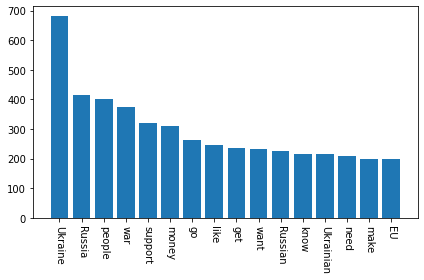

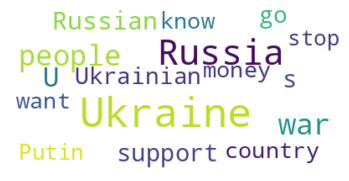

In [191]:
# a
# Obrób tweety technikami modelu bag-of-words, przefiltruj i zostaw najczęstsze i
# najciekawsze. Zobrazuj je na wykresie słupkowym i w chmurze tagów.

stopWords = nltk.corpus.stopwords.words("english")
stopWords.extend(
    ['.', '..', '...', '....', '.....', ',', '-', '?', '$', '!', ':', ';', '*', '&', '&amp;', '(', ')', '„', "'", '’',
     '‘', "''", '”', '“', '%', '\n'])

all_lemmatized_sentence = []
for i in range(len(tweets_df)):
    filteredSentence = []
    lemmatized_sentence = " "
    sentence = tweets_df.loc[i]['Text'].split()
    for word in sentence:
        if (word.find('https://') == -1) and (word.find('@') == -1) and (word.find('#') == -1) and (not word.lower() in stopWords):
            filteredSentence.append(word)
    lem = nltk.stem.wordnet.WordNetLemmatizer()
    for w in filteredSentence:
        lemmatized_sentence += lem.lemmatize(w, "v") + " "
        all_lemmatized_sentence.append(lem.lemmatize(w, "v"))
    tweets_df.loc[i, 'Text'] = lemmatized_sentence

fdist = nltk.probability.FreqDist(all_lemmatized_sentence)
plot = fdist.most_common(16)
x = []
y = []
for word in plot:
    x.append(word[0])
    y.append(word[1])
plt.bar(x, y)
plt.xticks(rotation=-90)
plt.tight_layout()
plt.show()

uniqueString = (" ").join(all_lemmatized_sentence)
wordcloud = WordCloud(max_font_size=50, max_words=len(plot), background_color="white").generate(uniqueString)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


positive_tweet:


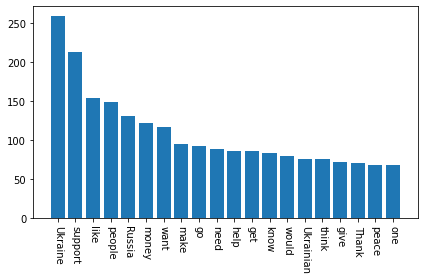

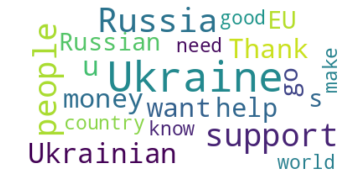

negative_tweet:


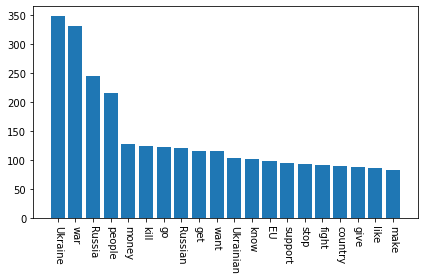

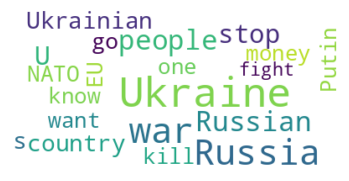

In [192]:
# b
# Podziel te tweety na pozytywne i negatywne, i dla każdej grupy zrób osobne chmury
# tagów. Czy się znacząco różnią? Być może podzielić tweety na więcej grup?

positive_tweet = []
positive_tweet_str = " "
negative_tweets = []
negative_tweets_str = " "
neutral_tweets = []
neutral_tweets_str = " "
for i in range(len(tweets_df)):
    score = sentiment_scores(tweets_df.loc[i]['Text'])
    if score > 0:
        #positive_tweet.append(tweets_df.loc[i])
        positive_tweet_str += tweets_df.loc[i]['Text']
    elif score < 0:
        #negative_tweets.append(tweets_df.loc[i])
        negative_tweets_str += tweets_df.loc[i]['Text']
    else:
        #neutral_tweets.append(tweets_df.loc[i])
        neutral_tweets_str += tweets_df.loc[i]['Text']

print("positive_tweet:")
fdist = nltk.probability.FreqDist(positive_tweet_str.split())
plot_p = fdist.most_common(20)
x_positive = []
y_positive = []
for word in plot_p:
    x_positive.append(word[0])
    y_positive.append(word[1])
plt.bar(x_positive, y_positive)
plt.xticks(rotation=-90)
plt.tight_layout()
plt.show()

wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(positive_tweet_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

print("negative_tweet:")
fdist = nltk.probability.FreqDist(negative_tweets_str.split())
plot_n = fdist.most_common(20)
x_negative = []
y_negative = []
for word in plot_n:
    x_negative.append(word[0])
    y_negative.append(word[1])
plt.bar(x_negative, y_negative)
plt.xticks(rotation=-90)
plt.tight_layout()
plt.show()

wordcloud = WordCloud(max_font_size=50, max_words=20, background_color="white").generate(negative_tweets_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

simple similarity  0.65
scoring similarity 0.4275
euclidean score:  0.6677452319751354
pearson score score:  0.6465507192464245
common words:


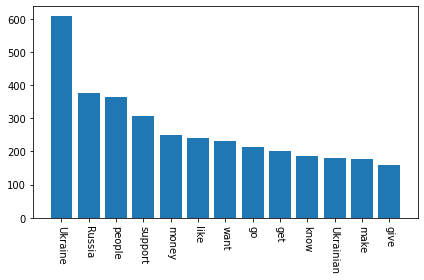

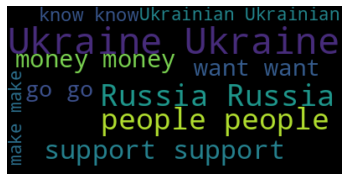

In [215]:
# c
# Czy chmury tagów mają spójną tematykę? Sprawdź podobieństwa wyrazów stosując
# np. WUP similarity i przedstaw to w ciekawej formie.


print("simple similarity ", simple_similarity(x_positive, x_negative))
print("scoring similarity", scoring_similarity(x_positive, x_negative))
print("euclidean score: ", euclidean_score(plot_p, plot_n))
print("pearson score score: ", pearson_score(plot_p, plot_n))

common_str = ""
for i in range(len(plot_p)):
    for j in range(len(plot_n)):
        if plot_p[i][0] == plot_n[j][0]:
            number_of_word_in_positive = plot_p[i][1]
            number_of_word_in_negative = plot_n[j][1]
            for x in range(number_of_word_in_positive + number_of_word_in_negative):
                common_str += (plot_p[i][0] + ' ')

print("common words:")
fdist = nltk.probability.FreqDist(common_str.split())
plot = fdist.most_common(20)
x = []
y = []
for word in plot:
    x.append(word[0])
    y.append(word[1])
plt.bar(x, y)
plt.xticks(rotation=-90)
plt.tight_layout()
plt.show()

wordcloud = WordCloud(max_font_size=50, max_words=10).generate(common_str)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wnioski
Chmura słów nie wybiera najczęstrzych słów więc nie jest wyznacznikiem zbyt dobrym wyznacznikiem częstości występowania słów.
Pozytywne tweety różnią się od negatywnych mniejszą liczbą negatywnych słów jak war, kill. W zamian ma więcej słów bardziej humanistycznych jak people, support czy help.
Tweety możnaby podzielić jeszcze na te mówiące raczej o Ukrainie i na te wypowiadające się o Rosji.
Mimo różnic wszystkie tweety dla tag = "ZelenskyyUa" większość mówi o obecnej wojnie.

Aby pobrać najnowsze tweety należy w pierwszej komórce podmienić linię 112 na 111.
